# **Import Moduls**

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os

#the basics
import pandas as pd, numpy as np, seaborn as sns
import math, json
from matplotlib import pyplot as plt
from tqdm import tqdm

#for model evaluation
from sklearn.model_selection import train_test_split, KFold

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **Persiapan Dataset Kaggle**

In [2]:
#install Kaggle
!pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hendricoyehezky","key":"5e0f8e205c85eaf2fa1accc496ed0fa5"}'}

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets list -s 'stanford-covid-vaccine'

ref                                                                    title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datasets/mathurinache/augmented-data-for-stanford-covid-vaccine        Augmented Data for Stanford Covid Vaccine             5MB  2020-10-04 12:50:36            261         45  0.9117647        
datasets/kfujikawa/stanford-covid-vaccine-kf-packages                  stanford-covid-vaccine-kf-packages                   37KB  2020-10-18 14:19:24              6          3  0.4375           
datasets/strider1125/openvaccine3dstructures                           Open Vaccine 3D Structures                          379MB  2020-10-08 03:13:44             30          6  0.9375           
datasets/fatihozturk/open

In [8]:
!kaggle competitions download -c stanford-covid-vaccine

 98% 88.0M/89.8M [00:00<00:00, 166MB/s]
100% 89.8M/89.8M [00:00<00:00, 176MB/s]


In [9]:
!unzip /content/stanford-covid-vaccine.zip

Streaming output truncated to the last 5000 lines.
  inflating: bpps/id_3397e6fde.npy   
  inflating: bpps/id_33b33ce4e.npy   
  inflating: bpps/id_33b754424.npy   
  inflating: bpps/id_33bd903ba.npy   
  inflating: bpps/id_33cbe6509.npy   
  inflating: bpps/id_33cfa91dc.npy   
  inflating: bpps/id_33d4dc6d0.npy   
  inflating: bpps/id_33e8cdd16.npy   
  inflating: bpps/id_33ea0b43b.npy   
  inflating: bpps/id_33f606ec5.npy   
  inflating: bpps/id_3406dc4f8.npy   
  inflating: bpps/id_340d5ef56.npy   
  inflating: bpps/id_34201072a.npy   
  inflating: bpps/id_34202b68b.npy   
  inflating: bpps/id_34286a9d3.npy   
  inflating: bpps/id_34340f0bf.npy   
  inflating: bpps/id_344128dc3.npy   
  inflating: bpps/id_344a913eb.npy   
  inflating: bpps/id_3453672f8.npy   
  inflating: bpps/id_34541b2fa.npy   
  inflating: bpps/id_345bc28db.npy   
  inflating: bpps/id_345ff4df9.npy   
  inflating: bpps/id_3467ded35.npy   
  inflating: bpps/id_34685be76.npy   
  inflating: bpps/id_346f56b43.npy   

In [10]:
#get comp data
train = pd.read_json('/content/train.json', lines=True)
test = pd.read_json('/content/test.json', lines=True)
sample_sub = pd.read_csv('/content/sample_submission.csv')

# **Eksplorasi dan Pre-proscessing Data**

In [11]:
#Checking Missing Values Data Train
print(train.shape)
if ~ train.isnull().values.any(): print('No missing values')
train.head()

(2400, 19)
No missing values


,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


In [12]:
#Checking Missing Values Data Test
print(test.shape)
if ~ test.isnull().values.any(): print('No missing values')
test.head()

(3634, 7)
No missing values


,index,id,sequence,structure,predicted_loop_type,seq_length,seq_scored
0,0,id_00073f8be,GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...,......((((((((((.(((((.....))))))))((((((((......,EEEEEESSSSSSSSSSBSSSSSHHHHHSSSSSSSSSSSSSSSSHHH...,107,68
1,1,id_000ae4237,GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...,.....((((..((((((...(((((.....((((....)))).......,EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIII...,130,91
2,2,id_00131c573,GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...,...........((.(((.(.(..((..((..((((...))))..))...,EEEEEEEEEEESSISSSISISIISSIISSIISSSSHHHSSSSIISS...,107,68
3,3,id_00181fd34,GGAAAGGAUCUCUAUCGAAGGAUAGAGAUCGCUCGCGACGGCACGA...,......((((((((((....))))))))))((((((..((.(((.....,EEEEEESSSSSSSSSSHHHHSSSSSSSSSSSSSSSSIISSISSSHH...,107,68
4,4,id_0020473f7,GGAAACCCGCCCGCGCCCGCCCGCGCUGCUGCCGUGCCUCCUCUCC...,.....(((((((((((((((((((((((((((((((((((((((((...,EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,130,91


In [13]:
#Checking Missing Values Data Sample-Submission
print(sample_sub.shape)
if ~ sample_sub.isnull().values.any(): print('No missing values')
sample_sub.head()

(457953, 6)
No missing values


,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.0,0.0,0.0,0.0,0.0
1,id_00073f8be_1,0.0,0.0,0.0,0.0,0.0
2,id_00073f8be_2,0.0,0.0,0.0,0.0,0.0
3,id_00073f8be_3,0.0,0.0,0.0,0.0,0.0
4,id_00073f8be_4,0.0,0.0,0.0,0.0,0.0


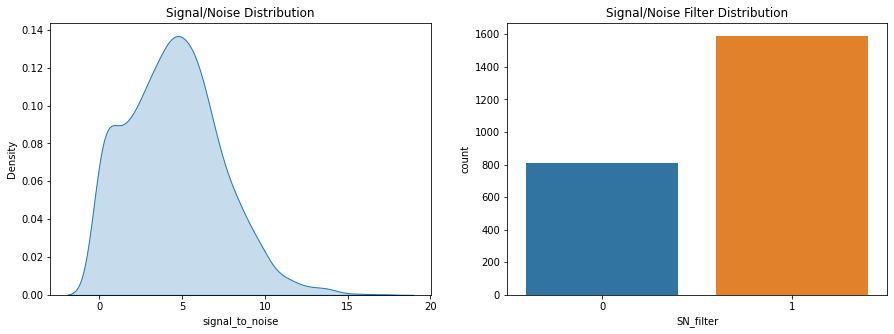

In [14]:
#Checking Noise Data
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
sns.kdeplot(train['signal_to_noise'], shade = True, ax = ax[0])
sns.countplot(train['SN_filter'], ax = ax[1])

ax[0].set_title('Signal/Noise Distribution')
ax[1].set_title('Signal/Noise Filter Distribution');

# **Pemrosesan Data**

In [15]:
#Proses Data 
target_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']


In [16]:
#Tokenisasi RNA
token2int = {x:i for i, x in enumerate('().ACGUBEHIMSX')}


In [17]:
def preprocess_inputs(df, cols=['sequence', 'structure', 'predicted_loop_type']):
    return np.transpose(
        np.array(
            df[cols]
            .applymap(lambda seq: [token2int[x] for x in seq])
            .values
            .tolist()
        ),
        (0, 2, 1)
    )

In [18]:
train_filtered = train.loc[train.SN_filter == 1]
train_inputs = torch.tensor(preprocess_inputs(train_filtered)).to(device)
print("input shape: ", train_inputs.shape)
train_labels = torch.tensor(
    np.array(train_filtered[target_cols].values.tolist()).transpose(0, 2, 1)
).float().to(device)
print("output shape: ", train_labels.shape)

input shape:  torch.Size([1589, 107, 3])
output shape:  torch.Size([1589, 68, 5])


# **Model RNN**
# **GRU dan LSTM**

In [19]:
class GRU_model(nn.Module):
    def __init__(
        self, seq_len=107, pred_len=68, dropout=0.5, embed_dim=100, hidden_dim=128, hidden_layers=3
    ):
        super(GRU_model, self).__init__()
        self.pred_len = pred_len

        self.embeding = nn.Embedding(num_embeddings=len(token2int), embedding_dim=embed_dim)
        self.gru = nn.GRU(
            input_size=embed_dim * 3,
            hidden_size=hidden_dim,
            num_layers=hidden_layers,
            dropout=dropout,
            bidirectional=True,
            batch_first=True,
        )
        self.linear = nn.Linear(hidden_dim * 2, 5)

    def forward(self, seqs):
        embed = self.embeding(seqs)
        reshaped = torch.reshape(embed, (-1, embed.shape[1], embed.shape[2] * embed.shape[3]))
        output, hidden = self.gru(reshaped)
        truncated = output[:, : self.pred_len, :]
        out = self.linear(truncated)
        return out
    
class LSTM_model(nn.Module):
    def __init__(
        self, seq_len=107, pred_len=68, dropout=0.5, embed_dim=100, hidden_dim=128, hidden_layers=3
    ):
        super(LSTM_model, self).__init__()
        self.pred_len = pred_len

        self.embeding = nn.Embedding(num_embeddings=len(token2int), embedding_dim=embed_dim)
        self.gru = nn.LSTM(
            input_size=embed_dim * 3,
            hidden_size=hidden_dim,
            num_layers=hidden_layers,
            dropout=dropout,
            bidirectional=True,
            batch_first=True,
        )
        self.linear = nn.Linear(hidden_dim * 2, 5)

    def forward(self, seqs):
        embed = self.embeding(seqs)
        reshaped = torch.reshape(embed, (-1, embed.shape[1], embed.shape[2] * embed.shape[3]))
        output, hidden = self.gru(reshaped)
        truncated = output[:, : self.pred_len, :]
        out = self.linear(truncated)
        return out
    
mse_loss = nn.MSELoss()
def compute_loss(batch_X, batch_Y, model, optimizer=None, is_train=True):
    model.train(is_train)

    pred_Y = model(batch_X)

    loss = mse_loss(pred_Y, batch_Y)

    if is_train:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss.item()

# **Konfigurasi Parameter Model Training dan Model Inferensial**

In [20]:
#Konfigurasi Proses Training
FOLDS = 4
EPOCHS = 90
BATCH_SIZE = 64
VERBOSE = 2
LR = 0.01

In [21]:
public_df = test.query("seq_length == 107").copy()
private_df = test.query("seq_length == 130").copy()

public_inputs = torch.tensor(preprocess_inputs(public_df)).to(device)
private_inputs = torch.tensor(preprocess_inputs(private_df)).to(device)

public_loader = DataLoader(TensorDataset(public_inputs), shuffle=False, batch_size=BATCH_SIZE)
private_loader = DataLoader(TensorDataset(private_inputs), shuffle=False, batch_size=BATCH_SIZE)

# **MODEL TRAINING GRU**

In [22]:
gru_histories = []
gru_private_preds = np.zeros((private_df.shape[0], 130, 5))
gru_public_preds = np.zeros((public_df.shape[0], 107, 5))

kfold = KFold(FOLDS, shuffle=True, random_state=2020)

for k, (train_index, val_index) in enumerate(kfold.split(train_inputs)):
    train_dataset = TensorDataset(train_inputs[train_index], train_labels[train_index])
    val_dataset = TensorDataset(train_inputs[val_index], train_labels[val_index])

    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
    val_loader = DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE)

    model = GRU_model().to(device)
    optimizer = optim.Adam(model.parameters(), lr=LR)

    train_losses = []
    val_losses = []
    for epoch in tqdm(range(EPOCHS)):
        train_losses_batch = []
        val_losses_batch = []
        for (batch_X, batch_Y) in train_loader:
            train_loss = compute_loss(batch_X, batch_Y, model, optimizer=optimizer, is_train=True)
            train_losses_batch.append(train_loss)
        for (batch_X, batch_Y) in val_loader:
            val_loss = compute_loss(batch_X, batch_Y, model, optimizer=optimizer, is_train=False)
            val_losses_batch.append(val_loss)
        train_losses.append(sum(train_losses_batch) / len(train_losses_batch))
        val_losses.append(sum(val_losses_batch) / len(val_losses_batch))
    model_state = model.state_dict()
    del model
            
    gru_histories.append({'train_loss': train_losses, 'val_loss': val_losses})


    gru_short = GRU_model(seq_len=107, pred_len=107).to(device)
    gru_short.load_state_dict(model_state)
    gru_short.eval()
    gru_public_pred = np.ndarray((0, 107, 5))
    for batch in public_loader:
        batch_X = batch[0]
        pred = gru_short(batch_X).detach().cpu().numpy()
        gru_public_pred = np.concatenate([gru_public_pred, pred], axis=0)
    gru_public_preds += gru_public_pred / FOLDS

    gru_long = GRU_model(seq_len=130, pred_len=130).to(device)
    gru_long.load_state_dict(model_state)
    gru_long.eval()
    gru_private_pred = np.ndarray((0, 130, 5))
    for batch in private_loader:
        batch_X = batch[0]
        pred = gru_long(batch_X).detach().cpu().numpy()
        gru_private_pred = np.concatenate([gru_private_pred, pred], axis=0)
    gru_private_preds += gru_private_pred / FOLDS
    
    del gru_short, gru_long

100%|██████████| 90/90 [05:47<00:00,  3.86s/it]


# **MODEL TRAINING LSTM**

In [23]:
lstm_histories = []
lstm_private_preds = np.zeros((private_df.shape[0], 130, 5))
lstm_public_preds = np.zeros((public_df.shape[0], 107, 5))

kfold = KFold(FOLDS, shuffle=True, random_state=2020)

for k, (train_index, val_index) in enumerate(kfold.split(train_inputs)):
    train_dataset = TensorDataset(train_inputs[train_index], train_labels[train_index])
    val_dataset = TensorDataset(train_inputs[val_index], train_labels[val_index])

    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
    val_loader = DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE)

    model = LSTM_model().to(device)
    optimizer = optim.Adam(model.parameters(), lr=LR)

    train_losses = []
    val_losses = []
    for epoch in tqdm(range(EPOCHS)):
        train_losses_batch = []
        val_losses_batch = []
        for (batch_X, batch_Y) in train_loader:
            train_loss = compute_loss(batch_X, batch_Y, model, optimizer=optimizer, is_train=True)
            train_losses_batch.append(train_loss)
        for (batch_X, batch_Y) in val_loader:
            val_loss = compute_loss(batch_X, batch_Y, model, optimizer=optimizer, is_train=False)
            val_losses_batch.append(val_loss)
        train_losses.append(sum(train_losses_batch) / len(train_losses_batch))
        val_losses.append(sum(val_losses_batch) / len(val_losses_batch))
    model_state = model.state_dict()
    del model
            
    lstm_histories.append({'train_loss': train_losses, 'val_loss': val_losses})


    lstm_short = LSTM_model(seq_len=107, pred_len=107).to(device)
    lstm_short.load_state_dict(model_state)
    lstm_short.eval()
    lstm_public_pred = np.ndarray((0, 107, 5))
    for batch in public_loader:
        batch_X = batch[0]
        pred = lstm_short(batch_X).detach().cpu().numpy()
        lstm_public_pred = np.concatenate([lstm_public_pred, pred], axis=0)
    lstm_public_preds += lstm_public_pred / FOLDS

    lstm_long = LSTM_model(seq_len=130, pred_len=130).to(device)
    lstm_long.load_state_dict(model_state)
    lstm_long.eval()
    lstm_private_pred = np.ndarray((0, 130, 5))
    for batch in private_loader:
        batch_X = batch[0]
        pred = lstm_long(batch_X).detach().cpu().numpy()
        lstm_private_pred = np.concatenate([lstm_private_pred, pred], axis=0)
    lstm_private_preds += lstm_private_pred / FOLDS
    
    del lstm_short, lstm_long

100%|██████████| 90/90 [06:01<00:00,  4.02s/it]


# **Hasil Prediksi Model GRU**

In [24]:
preds_gru = []

for df, preds in [(public_df, gru_public_preds), (private_df, gru_private_preds)]:
    for i, uid in enumerate(df.id):
        single_pred = preds[i]

        single_df = pd.DataFrame(single_pred, columns=target_cols)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

        preds_gru.append(single_df)

preds_gru_df = pd.concat(preds_gru)
preds_gru_df.head()

,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C,id_seqpos
0,0.805383,0.733449,2.075011,0.612633,0.764306,id_00073f8be_0
1,2.545464,3.540198,4.548969,3.495846,2.937393,id_00073f8be_1
2,1.281443,0.647189,0.816316,0.908124,0.944518,id_00073f8be_2
3,1.246800,1.049861,1.139340,1.369602,1.245922,id_00073f8be_3
4,0.979713,0.770251,0.852977,1.005179,0.955206,id_00073f8be_4


# **Hasil Prediksi Model LSTM**

In [25]:
preds_lstm = []

for df, preds in [(public_df, lstm_public_preds), (private_df, lstm_private_preds)]:
    for i, uid in enumerate(df.id):
        single_pred = preds[i]

        single_df = pd.DataFrame(single_pred, columns=target_cols)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

        preds_lstm.append(single_df)

preds_lstm_df = pd.concat(preds_lstm)
preds_lstm_df.head()

,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C,id_seqpos
0,0.795084,0.709887,2.097191,0.569457,0.722667,id_00073f8be_0
1,2.746973,3.674454,4.860679,3.527126,2.935742,id_00073f8be_1
2,1.514069,0.567549,0.746965,0.688650,0.748900,id_00073f8be_2
3,1.427652,1.143275,1.357276,1.669742,1.553936,id_00073f8be_3
4,0.923557,0.719603,0.792656,0.984794,0.903952,id_00073f8be_4


# **Model Gabungan Model LSTM dan Model GRU**

In [26]:
blend_preds_df = pd.DataFrame()
blend_preds_df['id_seqpos'] = preds_gru_df['id_seqpos']
blend_preds_df['reactivity'] = .5*preds_gru_df['reactivity'] + .5*preds_lstm_df['reactivity']
blend_preds_df['deg_Mg_pH10'] = .5*preds_gru_df['deg_Mg_pH10'] + .5*preds_lstm_df['deg_Mg_pH10']
blend_preds_df['deg_pH10'] = .5*preds_gru_df['deg_pH10'] + .5*preds_lstm_df['deg_pH10']
blend_preds_df['deg_Mg_50C'] = .5*preds_gru_df['deg_Mg_50C'] + .5*preds_lstm_df['deg_Mg_50C']
blend_preds_df['deg_50C'] = .5*preds_gru_df['deg_50C'] + .5*preds_lstm_df['deg_50C']

# **Hasil Prediksi Gabungan Model LSTM dan Model GRU**

In [27]:
submission = sample_sub[['id_seqpos']].merge(blend_preds_df, on=['id_seqpos'])

#sanity check
submission.head()

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.800233,0.721668,2.086101,0.591045,0.743486
1,id_00073f8be_1,2.646219,3.607326,4.704824,3.511486,2.936568
2,id_00073f8be_2,1.397756,0.607369,0.781640,0.798387,0.846709
3,id_00073f8be_3,1.337226,1.096568,1.248308,1.519672,1.399929
4,id_00073f8be_4,0.951635,0.744927,0.822817,0.994987,0.929579
